<a href="https://colab.research.google.com/github/redwineyards/MNIST-digit-classifier/blob/main/cnn_digitclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [10]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
torch.manual_seed(2000)
if device.type=='cuda':
  torch.cuda.manual_seed_all(2000)

True


In [3]:
root='/content/data'
trans=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
training_set=torchvision.datasets.MNIST(root=root,train=True,transform=trans,download=True)
testing_set=torchvision.datasets.MNIST(root=root,train=False,transform=trans,download=True)

In [16]:
num_epochs=5
batch_size=128
learning_rate=0.0001
train_loader=torch.utils.data.DataLoader(training_set,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(testing_set,batch_size=batch_size,shuffle=True)

In [17]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet,self).__init__()
    self.l1=nn.Sequential(nn.Conv2d(1,32,kernel_size=7),nn.ReLU(),nn.MaxPool2d(kernel_size=2,stride=2))
    self.l2=nn.Sequential(nn.Conv2d(32,64,kernel_size=5,stride=2,padding=3),nn.ReLU(),nn.MaxPool2d(kernel_size=2))
    self.l3=nn.Sequential(nn.Conv2d(64,128,kernel_size=3,stride=2,padding=2),nn.ReLU(),nn.MaxPool2d(kernel_size=2))
    self.dropout=nn.Dropout()
    self.fc1=nn.Linear(128,512)
    self.fc2=nn.Linear(512,10)
    self.softmax=nn.Softmax(dim=1)
  
  def forward(self,x):
    out=self.l1(x)
    out=self.l2(out)
    out=self.l3(out)
    out=out.reshape(out.size(0), -1)
    out=self.dropout(out)
    out=self.fc1(out)
    out=self.fc2(out)
    out=self.softmax(out)
    return out

In [18]:
def train(model,train_loader,num_epochs,learning_rate):
  losses=[]
  accs=[]
  optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
  lossfn=nn.CrossEntropyLoss()
  model.train()
  for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(train_loader):
      images=images.to(device)
      labels=labels.to(device)
      outputs=model(images)
      loss=lossfn(outputs,labels)
      losses.append(loss)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      _,pred=torch.max(outputs.data,1)
      correct=(pred==labels).sum().item()
      acc=correct/labels.size(0)
      accs.append(acc)
      
      if (i + 1) % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs,loss.item(),acc* 100))
  return losses,accs

In [19]:
def evaluate(model,test_loader):
  model.eval()
  with torch.no_grad():
    total=0
    correct=0
    for i,(images,labels) in enumerate(test_loader):
      images=images.to(device)
      labels=labels.to(device)
      output=model(images)
      _,pred=torch.max(output.data,1)
      correct+=(pred==labels).sum().item()
      total+=labels.size(0)
    acc=correct/total
    print("model accuracy on MNIST test set:", acc*100)

In [20]:
model=ConvNet().to(device)
losses,accs=train(model,train_loader,num_epochs,learning_rate)

Epoch [1/5], Loss: 1.9282, Accuracy: 60.16%
Epoch [1/5], Loss: 1.7573, Accuracy: 75.78%
Epoch [1/5], Loss: 1.6899, Accuracy: 78.91%
Epoch [1/5], Loss: 1.6796, Accuracy: 78.91%
Epoch [2/5], Loss: 1.5671, Accuracy: 90.62%
Epoch [2/5], Loss: 1.5636, Accuracy: 89.84%
Epoch [2/5], Loss: 1.5872, Accuracy: 88.28%
Epoch [2/5], Loss: 1.5192, Accuracy: 95.31%
Epoch [3/5], Loss: 1.5404, Accuracy: 92.19%
Epoch [3/5], Loss: 1.5189, Accuracy: 95.31%
Epoch [3/5], Loss: 1.5180, Accuracy: 94.53%
Epoch [3/5], Loss: 1.5181, Accuracy: 96.88%
Epoch [4/5], Loss: 1.5224, Accuracy: 95.31%
Epoch [4/5], Loss: 1.5293, Accuracy: 92.19%
Epoch [4/5], Loss: 1.4865, Accuracy: 98.44%
Epoch [4/5], Loss: 1.4870, Accuracy: 97.66%
Epoch [5/5], Loss: 1.5081, Accuracy: 95.31%
Epoch [5/5], Loss: 1.5045, Accuracy: 96.09%
Epoch [5/5], Loss: 1.5053, Accuracy: 95.31%
Epoch [5/5], Loss: 1.4913, Accuracy: 97.66%


In [21]:
evaluate(model,test_loader)

model accuracy on MNIST test set: 97.74000000000001


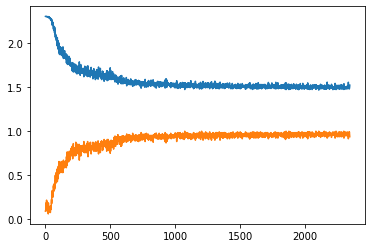

In [22]:
plt.plot(losses)
plt.plot(accs)